Introduction to GPU Programming Summer School
========================

D. Quigley, University of Warwick

---

# Tutorial 2: Kernels

## What is a kernel?

* #### A function which operates on an element of data and is executed by a CUDA thread
* #### We launch enough threads such that the operation is performed on all elements
* #### Threads are mapped onto our data via a grid of thread blocks
* #### Each instances of the function (thread) must be able to identify its location in the grid 
* #### Kernels are launched/invoked by the host, but run on the GPU\*

(* Newer version of CUDA allow kernels to launch kernels, but numba doesn't support this yet)

---

## Kernel limitations

* #### Can only return data via arguments to the kernel function - no return value
* #### Kernels cannot perform input or output - no printing or reading/writing files
* #### Exception handling inside kernels is limited
* #### Only a subset of the host language (e.g. Python or C) is supported
* #### Threads execute in lockstep within **warps** of 32 threads which map onto multiprocessors (groups of cores)


The final limitation might seem unimportant, but this means that anything which causes one thread in a warp to wait (e.g. for data to arrive from memory) will cause all threads to wait. Similary branches, (if statements) are problematic. Each thread must execute both branches and then decide which result to keep which may subvert traditional expectations of how to optimise code.

---

## Thread blocks/grids

* #### Threads within a block can make use of some *shared device memory* - more on that in tutorial 3
* #### All threads can read/write to global device memory. This is where all our device arrays have been so far
* #### There are hardware limitations on the number of threads per block
* #### The grid can be 1D, 2D or 3D

See https://numba.pydata.org/numba-doc/dev/cuda/cudapysupported.html for supported features. In particular note that numpy functions which dynamically create new arrays are not allowed in kernels.

## Trivial Example

This all makes more sense with an example. 

Let's start with the kernel we need to improve the porg example from Tutorial 2. Recall that we want to multiple each element in a 2D matrix by the corresponding element in another matrix. This suggests we use a 2D grid of threads with one thread per matrix element.

Our kernel looks like this:

In [1]:
import numpy as np
from numba import cuda

@cuda.jit
def multiply_elements(a, b, c):
    """
    Element-wise multiplication of a and b stored in c.
    """

    # What elements of a,b and c should this thread operate on?
    tx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    ty = cuda.threadIdx.y + cuda.blockDim.y * cuda.blockIdx.y

    # Better make sure the indices tx adn ty are inside the array!
    if ty < a.shape[0] and tx < a.shape[1]:
        c[ty,tx] = a[ty,tx] * b[ty,tx]

We've *decorated* this function with the identifier ```@cuda.jit``` which requires some explanation. Numba contains functionality to turn python functions into complied GPU code when first invoked. This is known as "just In time compilation" and will be familiar to Julia fans. Note that numba can also "jit" functions which run on the host (CPU) which might be useful if wanting to make fair CPU vs GPU benchmarks.



The next part of the function uses variables defined for us by CUDA which give each thread (i.e. instance of the function) a unique element of the thread grid to operate on...


```python
cuda.threadIdx.x  # Index of this thread within its block (x - direction)
cuda.blockIdx.x   # Which block of threads is this (x - direction)
cuda.blockDim.x   # Number of threads in each block (x - direction)
```

... plus similar in the y direction (and z if in 3D). To get the global position inside the grid we perform the computation 

```python
tx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
```

i.e. add the thread index within the current block thread to the number of threads in all previous blocks.

Finally we check that the resulting indices `tx` and `ty` will have something to operate on by comparing them to corresponding array sizes before addressing the arrays to perform the desired computation **on this single element **. Note that I'm being sloppy here and assuming somebody else has made sure `a`, `b` and `c` are all the same size/shape.


```python
if ty < a.shape[0] and tx < a.shape[1]:
        c[ty,tx] = a[ty,tx] * b[ty,tx]
```

This may seem unnecessary but is essential good practice. We have to use a whole number of blocks in the grid, which can often mean we launch more threads than necessary. The extra threads shouldn't try to write to memory which lies outside of the array or they'd be overwriting other data which we might need!

Next we need to know how to launch the kernel. Start with a trivial example using a 3x3 matrix for both of the inputs arrays such that the output should just contain the squares of the input.

In [2]:
# Create a array for the input data and copy it to the device
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=np.float)
d_a = cuda.to_device(a)

# Create an array for the output
d_c = cuda.device_array((3, 3),dtype=np.float)

In [3]:
# Now launch one thread per element, passing the *device* arrays to the kernel function
multiply_elements[(1, 1), (3, 3)](d_a, d_a, d_c)

The function call looks like a normal python function call, but the arguments are prefixed by a 2-element list which specifies the of number of blocks in the grid (first element) and the threads per block (second argument). For our 2D array each element in the list is a tuple specifying the size in each grid direction.

Here I've used one block of 3x3 threads mapping onto my 3x3 matrices. Lets check the result.

In [4]:
# Copy data back from the device to the host
c = d_c.copy_to_host()
print(c)

[[  1.   4.   9.]
 [ 16.  25.  36.]
 [ 49.  64.  81.]]


Hoorah!

I might have used 9x9 blocks of 1 thread each, but for bigger problems there are some things to think about.

* Threads are organised into warps of 32 - block sizes which are not a multiple of 32 will end up wasting some of a multiprocessor
* It might be desirable to maximise block size and hence the number of threads with access to the same *shared memory* 
* Each device has a maximum number of threads allowed per block. This can be queried in CUDA C codes but for our purposes we can check [the wikipedia page on CUDA](https://en.wikipedia.org/wiki/CUDA).

## Revenge of the Porg

Let's return to our image example from tutorial 1 and roughly (i.e. inside the notebook) the time taken for the whole convolution.

First we need the re-read the image and create the 2D Gaussian we want to convolute with.

In [5]:
from PIL import Image        # Import the Python Image Library
import pyculib.fft as cufft  # Import the cuFFT library interface

# Open an image file and convert to single colour (greyscale)
img = Image.open('porg.jpg').convert('L')
img_data = np.asarray(img,dtype=float)
dim = img_data.shape[0]

# Define the Gaussian to volume with
width = 0.2
domain = np.linspace(-5, 5,dim)
gauss = np.exp(-0.5*domain**2/(width*width)) 
shift = int(dim/2)
gauss = np.roll(gauss,shift)
gauss2D = gauss[:,np.newaxis] * gauss[np.newaxis,:]

Create all the arrays we need and move the input data onto the device

In [6]:
# Create event timers
event1 = cuda.event(timing=True)
event2 = cuda.event(timing=True)

# Make the data complex
img_data_complex = img_data + 1j * np.zeros((dim,dim))
gauss2D_complex = gauss2D + 1j * np.zeros((dim,dim))

# Arrays to store intermediate result and final output on host
img_fft = np.empty((dim,dim),dtype=complex)
gauss_fft = np.empty((dim,dim),dtype=complex)
img_ifft = np.empty((dim,dim),dtype=complex)

# Put the data on the device
d_img_data_complex = cuda.to_device(img_data_complex)
d_gauss2D_complex = cuda.to_device(gauss2D_complex)

# Create device arrays
d_img_fft = cuda.device_array((dim,dim),dtype=np.complex)
d_gauss_fft = cuda.device_array((dim,dim),dtype=np.complex)
d_img_ifft = cuda.device_array((dim,dim),dtype=np.complex)

Perform the convolution the way we did it yesterday

In [11]:
event1.record()  # Start timer

# FFT the two input arrays
cufft.fft(d_img_data_complex,d_img_fft)
cufft.fft(d_gauss2D_complex,d_gauss_fft)

# Copy data back to host
img_fft=d_img_fft.copy_to_host()
gauss_fft = d_gauss_fft.copy_to_host()

# Multiply each element in fft_img by the corresponding image in fft_gaus
img_conv = img_fft * gauss_fft

# Copy to the device
d_img_conv = cuda.to_device(img_conv)

# Inverse Fourier transform
cufft.ifft(d_img_conv,d_img_ifft)
        
# Copy result back to host
img_ifft = d_img_ifft.copy_to_host()

event2.record()  # Stop timer

# Elapsed time (in milliseconds)
t = cuda.event_elapsed_time(event1,event2)
print("Convolution with multiplication on host took : ",t," milliseconds.")

Convolution with multiplication on host took :  188.91477966308594  milliseconds.


Now let's do the convolution using our new kernel, i.e. avoiding the need to copy data back to the host for the intermediate multiplication.

In [22]:
event1.record()  # Start timer

# FFT the two input arrays
cufft.fft(d_img_data_complex, d_img_fft)
cufft.fft(d_gauss2D_complex, d_gauss_fft)

# Use the kernel to multiply on the device
threads_per_block = 32
blocks_per_grid = dim // threads_per_block + 1

multiply_elements[blocks_per_grid, threads_per_block](d_img_fft, d_gauss_fft, d_img_conv)

# Inverse Fourier transform
cufft.ifft(d_img_conv, d_img_ifft)
        
# Copy result back to host
img_ifft = d_img_ifft.copy_to_host()

event2.record()  # Stop timer

# Elapsed time (in milliseconds)
t = cuda.event_elapsed_time(event1,event2)
print("Convolution with multiplication on device took : ",t," milliseconds.")

Convolution with multiplication on device took :  65.96991729736328  milliseconds.


You might see that that is slower than our old method.

BUT - remember that our kernel is compiled on first use so this slower time include the time taken to compile the kernel. Run the above cell again and you should see that there's a significant improvement and that avoiding the intermediate memory transfers between host and device has saved us a huge amount of time!

Let's check the porg is OK and appropriately blurred.

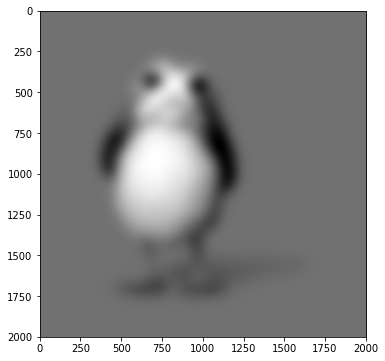

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# Show the porg
plt.figure(figsize = [6, 6])
plt.imshow(img_ifft.real,cmap='gray');

## Exercise

* Cut and paste from the above to create a script which benchmarks the two methods of performing the convolution. Gather timings on the Tinis GPU node as an average over 10 runs. Remember to exclude the first run of the kernel-based method from your average if you want to measure only execution time.

* How much faster than the orignal CPU-based numpy implementation is this version?

* (Advanced) Can the CPU version be made faster by 'jitting' a function for the multiplication?


## Mandelbrot set

## Conway's game of life